# RecB dissociation rates in ΔrecA and RecB1080

In [25]:
from pyberries.data import DatasetPool, Fit, get_histogram
import seaborn.objects as so
from seaborn import plotting_context
import pandas as pd

data = (DatasetPool(path='/media/daniel/HDD Daniel/DanielThedie/BACMMAN/Timelapse',
                    dsList=['230725_1', '230725_2', '230126_DT23', '230719_1', '230719_2', '240424_1', '240612_1', '240620_1',
                            '230201_DT22', '230919_1', '240424_3', '240612_3',
                            '230126_DT21', '230919_2', '230920_2', '240606_1', '240606_3',
                            '230118_DT23', '230720_1', '230720_2', '230726_cipro30', '230824_1', '230829_1', '230201_DT23', '230504_2sec', '230718_2sec', '240424_2', '240612_2', '240620_2',
                            '221222_cipro30ngmL', '230802_DT22', '230808_DT22', '230914_1', '240424_4', '240612_4',
                            '230802_DT21', '230913_2', '230914_2', '240606_2', '240606_4'],
                    groups=['WT, 0', 'WT, 0', 'WT, 0', 'WT, 0', 'WT, 0', 'WT, 0', 'WT, 0', 'WT, 0',
                            'ΔrecA, 0', 'ΔrecA, 0', 'ΔrecA, 0', 'ΔrecA, 0',
                            'RecB1080, 0', 'RecB1080, 0', 'RecB1080, 0', 'RecB1080, 0', 'RecB1080, 0',
                            'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL',
                            'ΔrecA, 30 ng/mL', 'ΔrecA, 30 ng/mL', 'ΔrecA, 30 ng/mL', 'ΔrecA, 30 ng/mL', 'ΔrecA, 30 ng/mL', 'ΔrecA, 30 ng/mL',
                            'RecB1080, 30 ng/mL', 'RecB1080, 30 ng/mL', 'RecB1080, 30 ng/mL', 'RecB1080, 30 ng/mL', 'RecB1080, 30 ng/mL'],
                    filters={'all':'Frame < 50'},
                    metadata='DateTime',
                    rename_objects={'Spot_detection':'RecB_spots'},
                    rename_cols={'SpotCount':'RecBSpotCount'}
                    )
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        .assign(Time_min=lambda df: df.Time_min + 15)
        .bin_column(col='Time_min', binsize=15, binlabels='left')
        .split_column(col='Group', new_cols=['Strain', 'Cipro'], delimiter=', ')
        )

Dataset 230725_1 (group WT, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230725_2 (group WT, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230126_DT23 (group WT, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_1 (group WT, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_2 (group WT, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 240424_1 (group WT, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240612_1 (group WT, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240620_1 (group WT, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 230201_DT22 (group ΔrecA, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230919_1 (group ΔrecA, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 240424_3

In [ ]:
data.describe(object_name='Bacteria_large')

## Bleaching rate fit

In [26]:
from pyberries.data import Fit

bleaching_fit = Fit(data.Bacteria_large, x='Frame', y='SNR', groupby=['Group', 'Strain', 'Cipro', 'Dataset'], model_type='monoexp_decay_offset', p0=[30000, 1, 0])

bleaching_rates = (bleaching_fit.parameters
                   .query('Parameter == "Rate"')
                   .assign(Adjusted_rate=lambda df: df.Value.div(2))  # Adjust rate to frame time
                   )

### Show fitted parameters

There are three fitted parameters in the model:
- Amplitude (adjusts the height of the first point)
- Rate (the bleaching rate)
- Offset (a constant offset that accounts for any cellular autofluorescence)

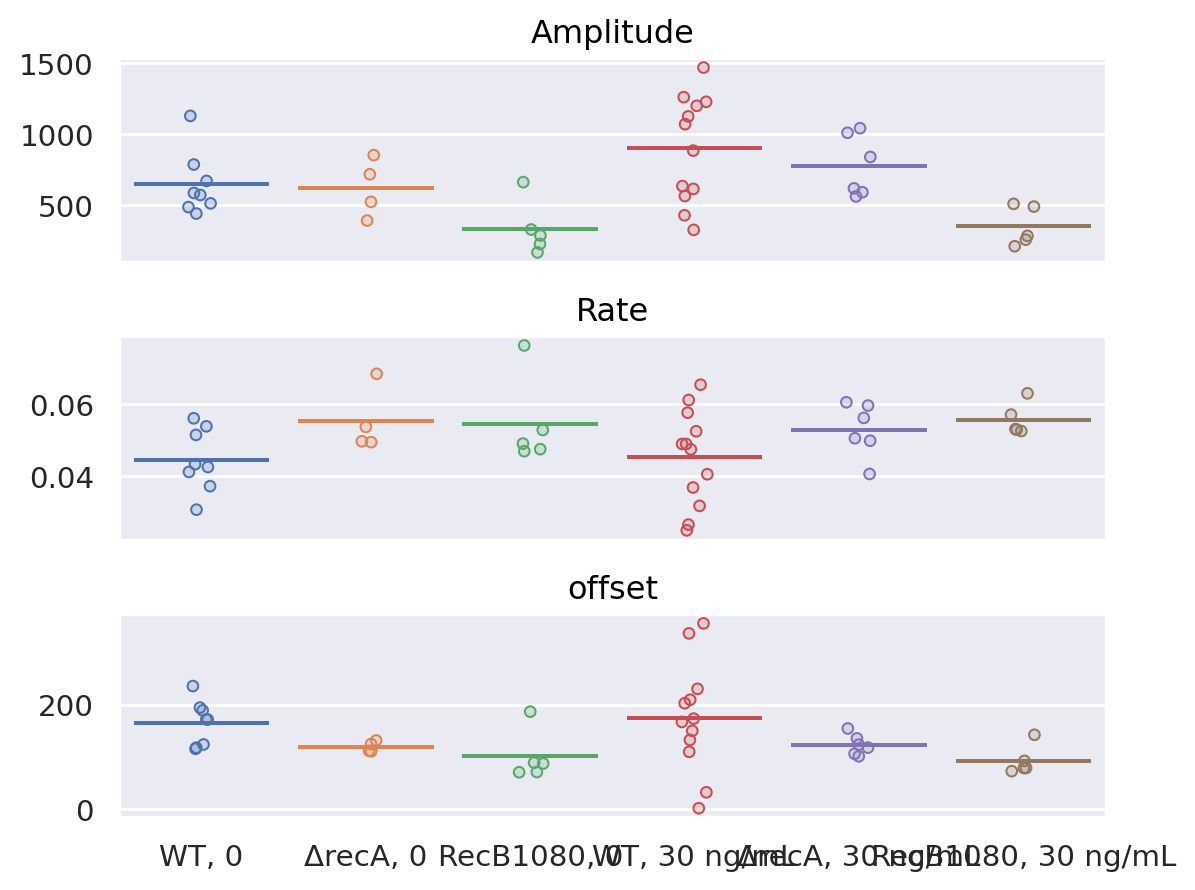

In [27]:
(
    so.Plot(bleaching_fit.parameters, x='Group', y='Value', color='Group')
    .facet(row='Parameter')
    .add(so.Dots(), so.Jitter(), legend=False)
    .add(so.Dash(), so.Agg(), legend=False)
    .scale(color='deep')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="", color='')
)

## RecB spot lifetime fit

### Bi-exponential fit

In [44]:
from pyberries.data import get_model

hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Dataset', 'Group', 'Strain', 'Cipro'], density=True, binlabels='left')
lifetime_fit = Fit(hist, x='TrackLength', y='proportion', model_type='biexp_decay', bootstrap_samples=100,
                   groupby=['Dataset', 'Group', 'Strain', 'Cipro'], p0=[1, 1, 0.1, 0.1])

monoexp_decay = get_model('monoexp_decay')

lifetime_fit.data[['Fit_fast', 'Fit_slow']] = pd.DataFrame(columns=['Fit_fast', 'Fit_slow'], dtype='float64')
for ds, df in lifetime_fit.data.groupby('Dataset'):
    params = lifetime_fit.parameters.query('Dataset == @ds')
    df = (df
          .assign(Fit_fast = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_1"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_1"').Value.iloc[0]),
                  Fit_slow = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_2"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_2"').Value.iloc[0])
                  )
          )
    lifetime_fit.data.loc[lifetime_fit.data.Dataset == ds,:] = df

Group ('230725_1', 'WT, 0', 'WT', '0'): 1 iterations failed
Group ('230725_2', 'WT, 0', 'WT', '0'): 1 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Group ('230126_DT23', 'WT, 0', 'WT', '0'): 5 iterations failed
Group ('230719_1', 'WT, 0', 'WT', '0'): 11 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Group ('230719_2', 'WT, 0', 'WT', '0'): 1 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('240612_1', 'WT, 0', 'WT', '0'): 25 iterations failed
Group ('240620_1', 'WT, 0', 'WT', '0'): 19 iterations failed
Group ('230201_DT22', 'ΔrecA, 0', 'ΔrecA', '0'): 1 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('240424_3', 'ΔrecA, 0', 'ΔrecA', '0'): 9 iterations failed
Group ('230126_DT21', 'RecB1080, 0', 'RecB1080', '0'): 2 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Group ('230920_2', 'RecB1080, 0', 'RecB1080', '0'): 1 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('240606_3', 'RecB1080, 0', 'RecB1080', '0'): 5 iterations failed
Group ('230118_DT23', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 8 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('230726_cipro30', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 4 iterations failed
Group ('230824_1', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 1 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('230829_1', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 4 iterations failed
Group ('230201_DT23', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 3 iterations failed
Group ('230504_2sec', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 3 iterations failed
Group ('230718_2sec', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 1 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('240424_2', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 1 iterations failed
Group ('240612_2', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 1 iterations failed
Group ('240620_2', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 2 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('240424_4', 'ΔrecA, 30 ng/mL', 'ΔrecA', '30 ng/mL'): 1 iterations failed
Group ('240612_4', 'ΔrecA, 30 ng/mL', 'ΔrecA', '30 ng/mL'): 13 iterations failed
Group ('230802_DT21', 'RecB1080, 30 ng/mL', 'RecB1080', '30 ng/mL'): 2 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('230913_2', 'RecB1080, 30 ng/mL', 'RecB1080', '30 ng/mL'): 1 iterations failed
Group ('240606_4', 'RecB1080, 30 ng/mL', 'RecB1080', '30 ng/mL'): 3 iterations failed


#### Plot fits

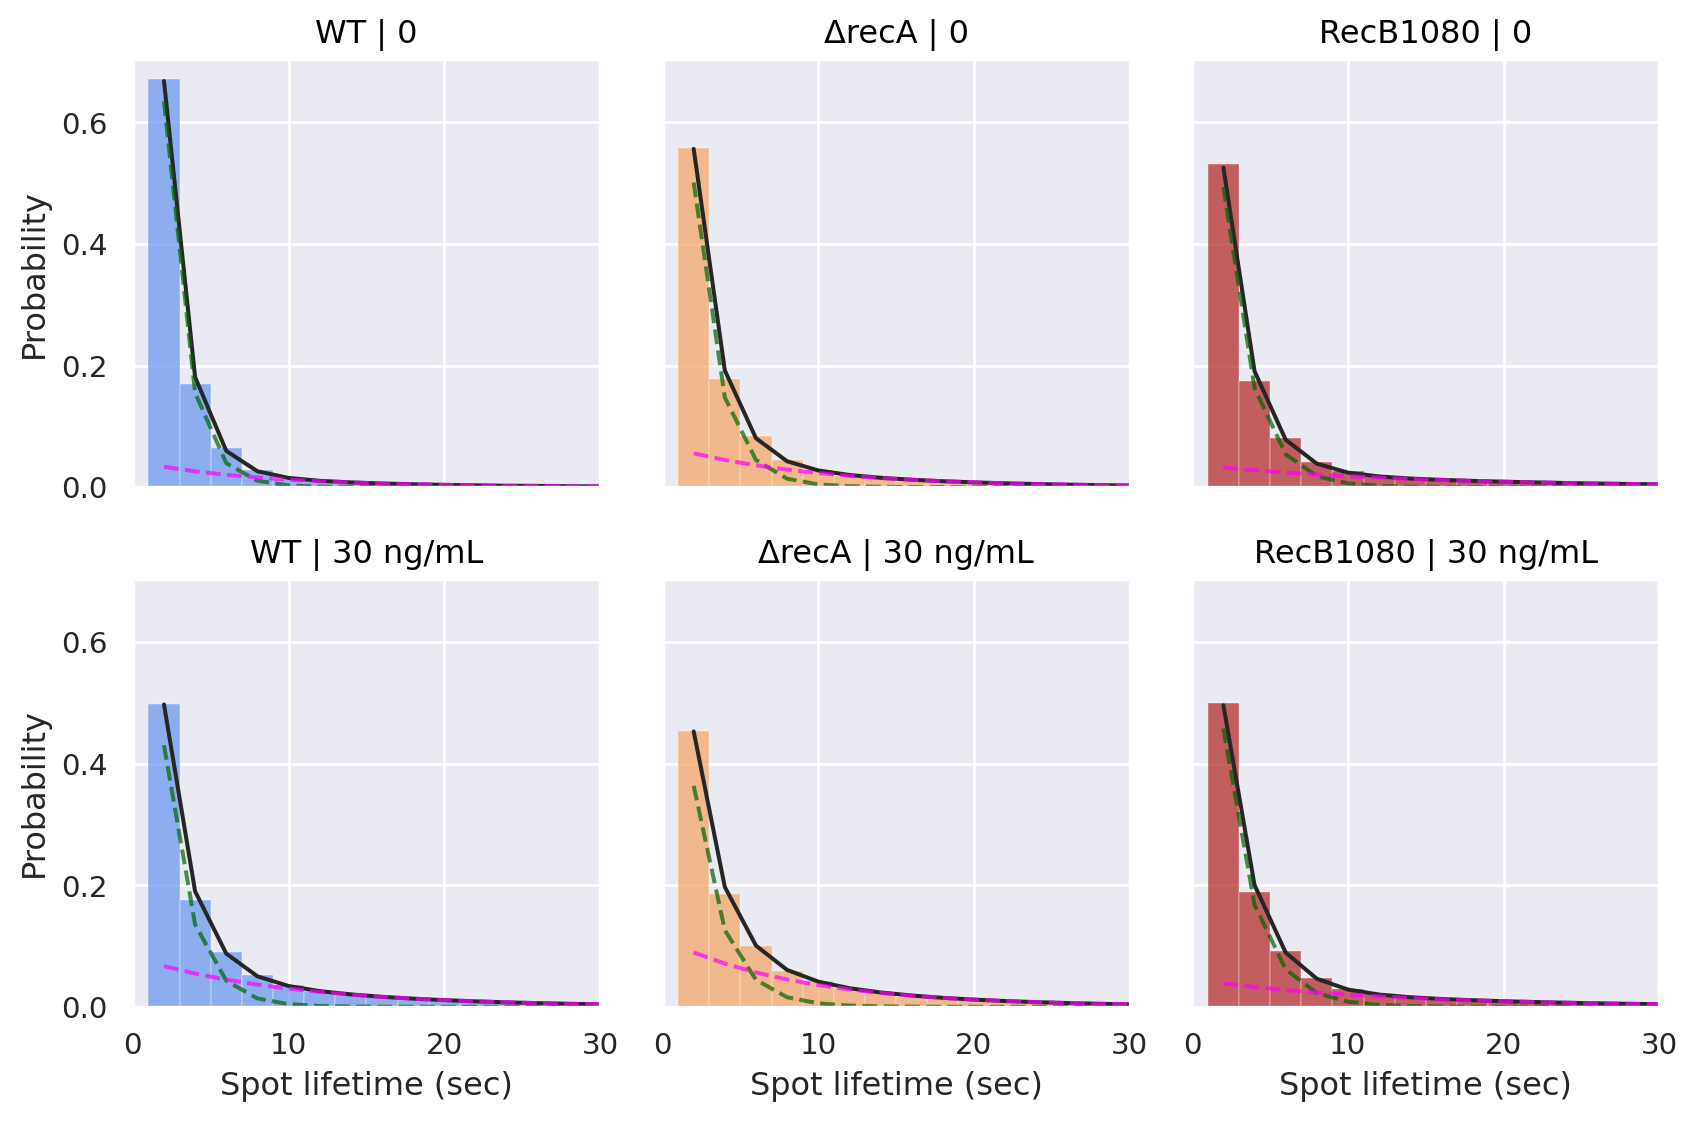

In [45]:
df = (lifetime_fit
      .data
      .assign(TrackLength_s=lambda df: df.TrackLength.mul(2))
      )

(
    so.Plot(df, x='TrackLength_s', color='Strain')
    .layout(size=(9, 6))
    .facet(col='Strain', row='Cipro')
    .add(so.Bars(), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k'), so.Agg(), y='Fit', legend=False)
    .add(so.Line(linestyle='--', color='darkgreen', alpha=0.7), so.Agg(), y='Fit_fast', legend=False)
    .add(so.Line(linestyle='--', color='fuchsia', alpha=0.7), so.Agg(), y='Fit_slow', legend=False)
    .limit(x=(0, 30), y=(None, None))
    .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick']))
    .label(x="Spot lifetime (sec)", y="Probability", color='')
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/Mutants_RecB_fits.pdf', format='pdf', bbox_inches='tight')
)

#### Proportion of spots with lifetime > 50 sec

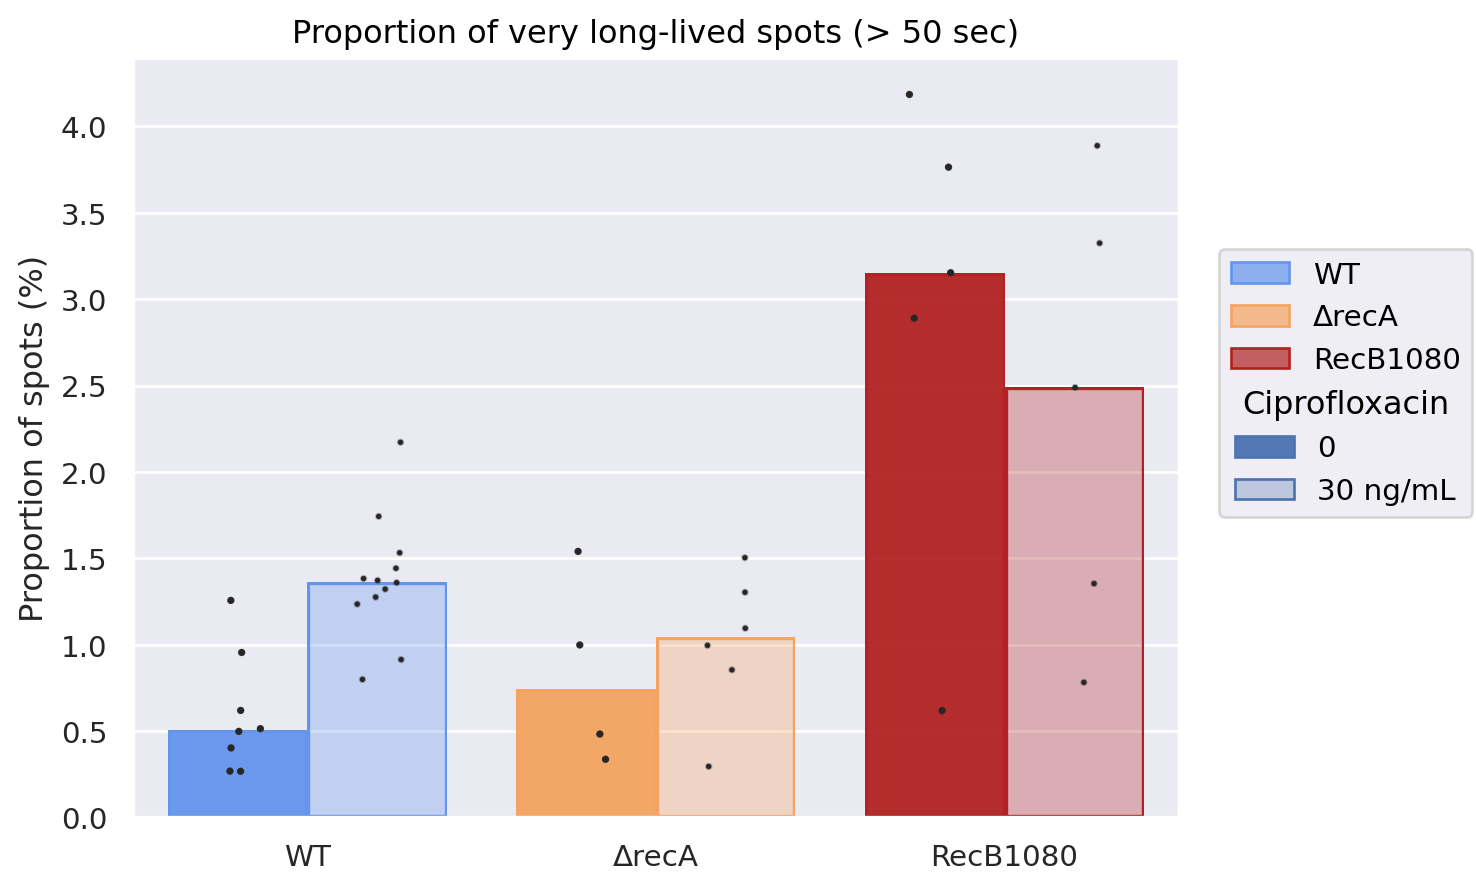

In [46]:
df = (data
      .RecB_spots
      .assign(vLong=lambda df: (df.TrackLength > 25).astype('int').mul(100))
      .groupby(['Group', 'Strain', 'Cipro', 'Dataset'])
      .agg({'vLong':'mean'})
      )

(
    so.Plot(df, x='Strain', y='vLong', color='Strain', alpha='Cipro')
    # .layout(size=(10,6))
    .add(so.Bar(), so.Agg('median'), so.Dodge(by=['alpha']))
    .add(so.Dots(color='k', marker='.', fillalpha=1), so.Jitter(), so.Dodge(by=['alpha']), legend=False)
    .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick'],
                            order=['WT', 'ΔrecA', 'RecB1080']),
           x=so.Nominal(order=['WT', 'ΔrecA', 'RecB1080']))
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="Proportion of spots (%)", color='', title='Proportion of very long-lived spots (> 50 sec)', alpha='Ciprofloxacin')
)

#### Calculating RecB spot lifetimes from the rates

In [47]:
def split_column(df, col, new, delimiter):
        df[new] = (df[col]
                        .str.split(delimiter, expand=True)
                        )
        return df

lifetimes_biexp = (lifetime_fit
                   .parameters
                   .copy()
                   .pipe(lambda df: split_column(df, col='Parameter', new=['Parameter', 'Rate_type'], delimiter='_'))
                   .replace({'1':'Short', '2':'Long'})
                   .merge(bleaching_rates[['Dataset', 'Value']], on='Dataset', suffixes=(None, '_bleaching'))
                   .pipe(lambda df: pd.pivot_table(df, values=['Value'], index=['Group', 'Strain', 'Cipro', 'Dataset', 'Value_bleaching'], columns=['Parameter', 'Rate_type']))
                   .reset_index()
                   .assign(Lifetime_Short=lambda df: 1/(df.Value.Rate.Short - df.Value_bleaching) *2,
                           Lifetime_Long=lambda df: 1/(df.Value.Rate.Long - df.Value_bleaching) *2,
                           Population_Long=lambda df: df.Value.Amplitude.Long/(df.Value.Amplitude.Short+df.Value.Amplitude.Long) *100,
                           Population_Short=lambda df: 100 - df.Population_Long
                           )
                   .drop(columns=['Value', 'Value_bleaching'], level=0)
                   .droplevel(['Parameter', 'Rate_type'], axis=1)
                   .melt(id_vars=['Group', 'Strain', 'Cipro', 'Dataset'])
                   .pipe(lambda df: split_column(df, col='variable', new=['Parameter', 'Rate_type'], delimiter='_'))
                   .drop(columns='variable')
                   )

#### Make a pretty lifetimes table

In [48]:
def fuse_cols(df, cols, new, delimiter):
        df[new] = (df[cols]
                   .astype('str')
                   .agg(delimiter.join, axis=1)
                   )
        return df

df = (lifetimes_biexp
      .pipe(lambda df: pd.pivot_table(df, values='value', index=['Strain', 'Cipro', 'Dataset', 'Rate_type'], columns='Parameter'))
      .groupby(['Strain', 'Cipro', 'Rate_type'], observed=True)
      .agg(Lifetime_mean=('Lifetime', 'mean'),
           Lifetime_std=('Lifetime', 'std'),
           Population_mean=('Population', 'mean'),
           Population_std=('Population', 'std')
           )
      .round(2)
      .reset_index()
      .assign(Strain=lambda df: df.Strain
                          .astype('category')
                          .cat.set_categories(['WT', 'ΔrecA', 'RecB1080'], ordered=True))
      .sort_values('Strain')
      .set_index(['Strain','Cipro','Rate_type'])
      )

display(df)

Lifetime_mean  Lifetime_std  Population_mean  \
Strain   Cipro    Rate_type                                                 
WT       0        Long               13.20          7.46             1.48   
                  Short               1.47          0.24            98.52   
         30 ng/mL Long               13.12          2.05             5.70   
                  Short               1.81          0.17            94.30   
ΔrecA    0        Long               12.40          1.64             3.84   
                  Short               1.72          0.26            96.16   
         30 ng/mL Long               12.20          3.35            10.00   
                  Short               2.01          0.24            90.00   
RecB1080 0        Long               31.59         21.98             2.45   
                  Short               1.90          0.11            97.55   
         30 ng/mL Long               20.19          6.89             3.53   
                  Short               2.11          0.10            96.47   

                             Population_std  
Strain   Cipro    Rate_type                  
WT       0        Long                 0.90  
                  Short                0.90  
         30 ng/mL Long                 1.35  
                  Short                1.35  
ΔrecA    0        Long                 1.15  
                  Short                1.15  
         30 ng/mL Long                 3.27  
                  Short                3.27  
RecB1080 0        Long                 0.89  
                  Short                0.89  
         30 ng/mL Long                 0.72  
                  Short                0.72

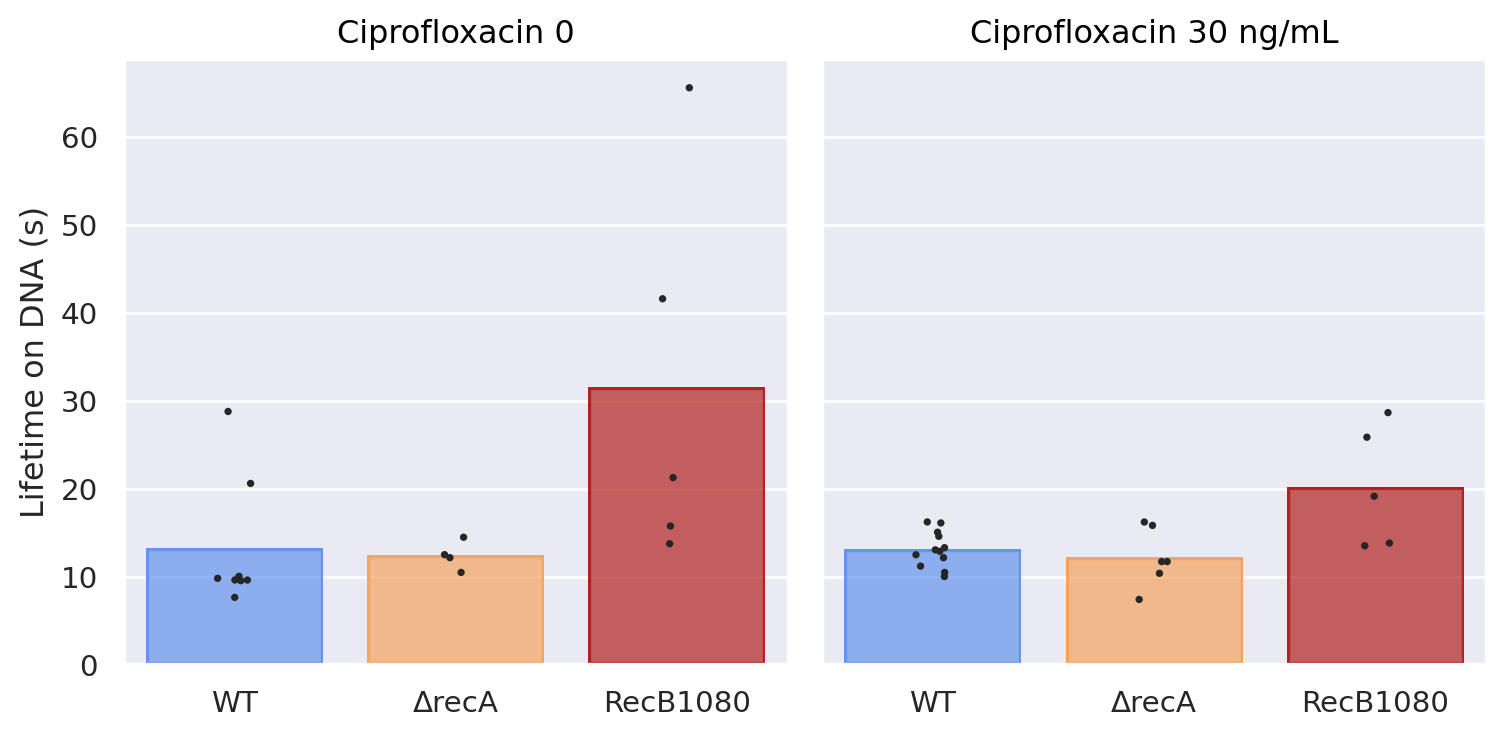

In [49]:
df = (lifetimes_biexp
      .replace({'Fast':'Short', 'Slow':'Long'})
      .query('Parameter == "Lifetime"  and Rate_type == "Long"')
      )

(
    so.Plot(df, x='Strain', y='value', color='Strain')
    .layout(size=(8, 4))
    .facet(col='Cipro')
    .add(so.Bar(), so.Agg('mean'), legend=False)
    .add(so.Dots(marker='.', color='k', fillalpha=1), so.Jitter(), legend=False)
    .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick'],
                            order=['WT', 'ΔrecA', 'RecB1080']),
           x=so.Nominal(order=['WT', 'ΔrecA', 'RecB1080'])
           )
    .share(y='row')
    .limit(y=(None, None))
    .label(x="", y="Lifetime on DNA (s)", color='', title="Ciprofloxacin {}".format)
    # .save(loc='D:\\DanielThedie\\Figures\\RecB_article_figures\\4_Mutants\\RecB_lifetimes.svg', format='svg', bbox_inches='tight')
)

### Triple exponential fit

In [50]:
import numpy as np

def model(x, Amplitude_1, Rate_1, Amplitude_2, Rate_2, Amplitude_3, Rate_3):
    return Amplitude_1*np.exp(-Rate_1*x, dtype='float64') + Amplitude_2*np.exp(-Rate_2*x, dtype='float64') + Amplitude_3*np.exp(-Rate_3*x, dtype='float64')

hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Dataset', 'Group', 'Strain', 'Cipro'], density=True, binlabels='left')
triexp_fit = Fit(hist, x='TrackLength', y='proportion', model=model, bootstrap_samples=10,
                 groupby=['Dataset', 'Group', 'Strain', 'Cipro'], p0=[1, 1, 0.5, 0.5, 0.1, 0.1])

Group ('230725_1', 'WT, 0', 'WT', '0'): 5 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('230725_2', 'WT, 0', 'WT', '0'): 5 iterations failed
Group ('230126_DT23', 'WT, 0', 'WT', '0'): 7 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Group ('230719_1', 'WT, 0', 'WT', '0'): 4 iterations failed
Group ('230719_2', 'WT, 0', 'WT', '0'): 5 iterations failed
Group ('240424_1', 'WT, 0', 'WT', '0'): 5 iterations failed
Group ('240612_1', 'WT, 0', 'WT', '0'): 5 iterations failed
Group ('240620_1', 'WT, 0', 'WT', '0'): 5 iterations failed
Group ('230201_DT22', 'ΔrecA, 0', 'ΔrecA', '0'): 7 iterations failed
Group ('240424_3', 'ΔrecA, 0', 'ΔrecA', '0'): 6 iterations failed
Group ('240612_3', 'ΔrecA, 0', 'ΔrecA', '0'): 2 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Group ('230126_DT21', 'RecB1080, 0', 'RecB1080', '0'): 3 iterations failed
Group ('230919_2', 'RecB1080, 0', 'RecB1080', '0'): 5 iterations failed
Group ('230920_2', 'RecB1080, 0', 'RecB1080', '0'): 7 iterations failed
Group ('240606_1', 'RecB1080, 0', 'RecB1080', '0'): 3 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Group ('240606_3', 'RecB1080, 0', 'RecB1080', '0'): 4 iterations failed
Group ('230118_DT23', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 3 iterations failed
Group ('230720_1', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 1 iterations failed
Group ('230720_2', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 1 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Group ('230726_cipro30', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 3 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('230824_1', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 3 iterations failed
Group ('230829_1', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 7 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('230201_DT23', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 5 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Group ('230504_2sec', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 7 iterations failed
Group ('230718_2sec', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 4 iterations failed
Group ('240424_2', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 2 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('240612_2', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 7 iterations failed
Group ('240620_2', 'WT, 30 ng/mL', 'WT', '30 ng/mL'): 4 iterations failed
Group ('221222_cipro30ngmL', 'ΔrecA, 30 ng/mL', 'ΔrecA', '30 ng/mL'): 4 iterations failed
Group ('230802_DT22', 'ΔrecA, 30 ng/mL', 'ΔrecA', '30 ng/mL'): 1 iterations failed
Group ('230808_DT22', 'ΔrecA, 30 ng/mL', 'ΔrecA', '30 ng/mL'): 4 iterations failed
Group ('230914_1', 'ΔrecA, 30 ng/mL', 'ΔrecA', '30 ng/mL'): 3 iterations failed
Group ('240424_4', 'ΔrecA, 30 ng/mL', 'ΔrecA', '30 ng/mL'): 4 iterations failed
Group ('240612_4', 'ΔrecA, 30 ng/mL', 'ΔrecA', '30 ng/mL'): 4 iterations failed
Group ('230802_DT21', 'RecB1080, 30 ng/mL', 'RecB1080', '30 ng/mL'): 4 iterations failed
Group ('230913_2', 'RecB1080, 30 ng/mL', 'RecB1080', '30 ng/mL'): 5 iterations failed
Group ('230914_2', 'RecB1080, 30 ng/mL', 'RecB1080', '30 ng/mL'): 4 iterations failed
Group ('240606_2', 'RecB1080, 30 ng/mL', 'RecB1080', '30 ng/mL'): 3 iterations failed


#### Plot fits

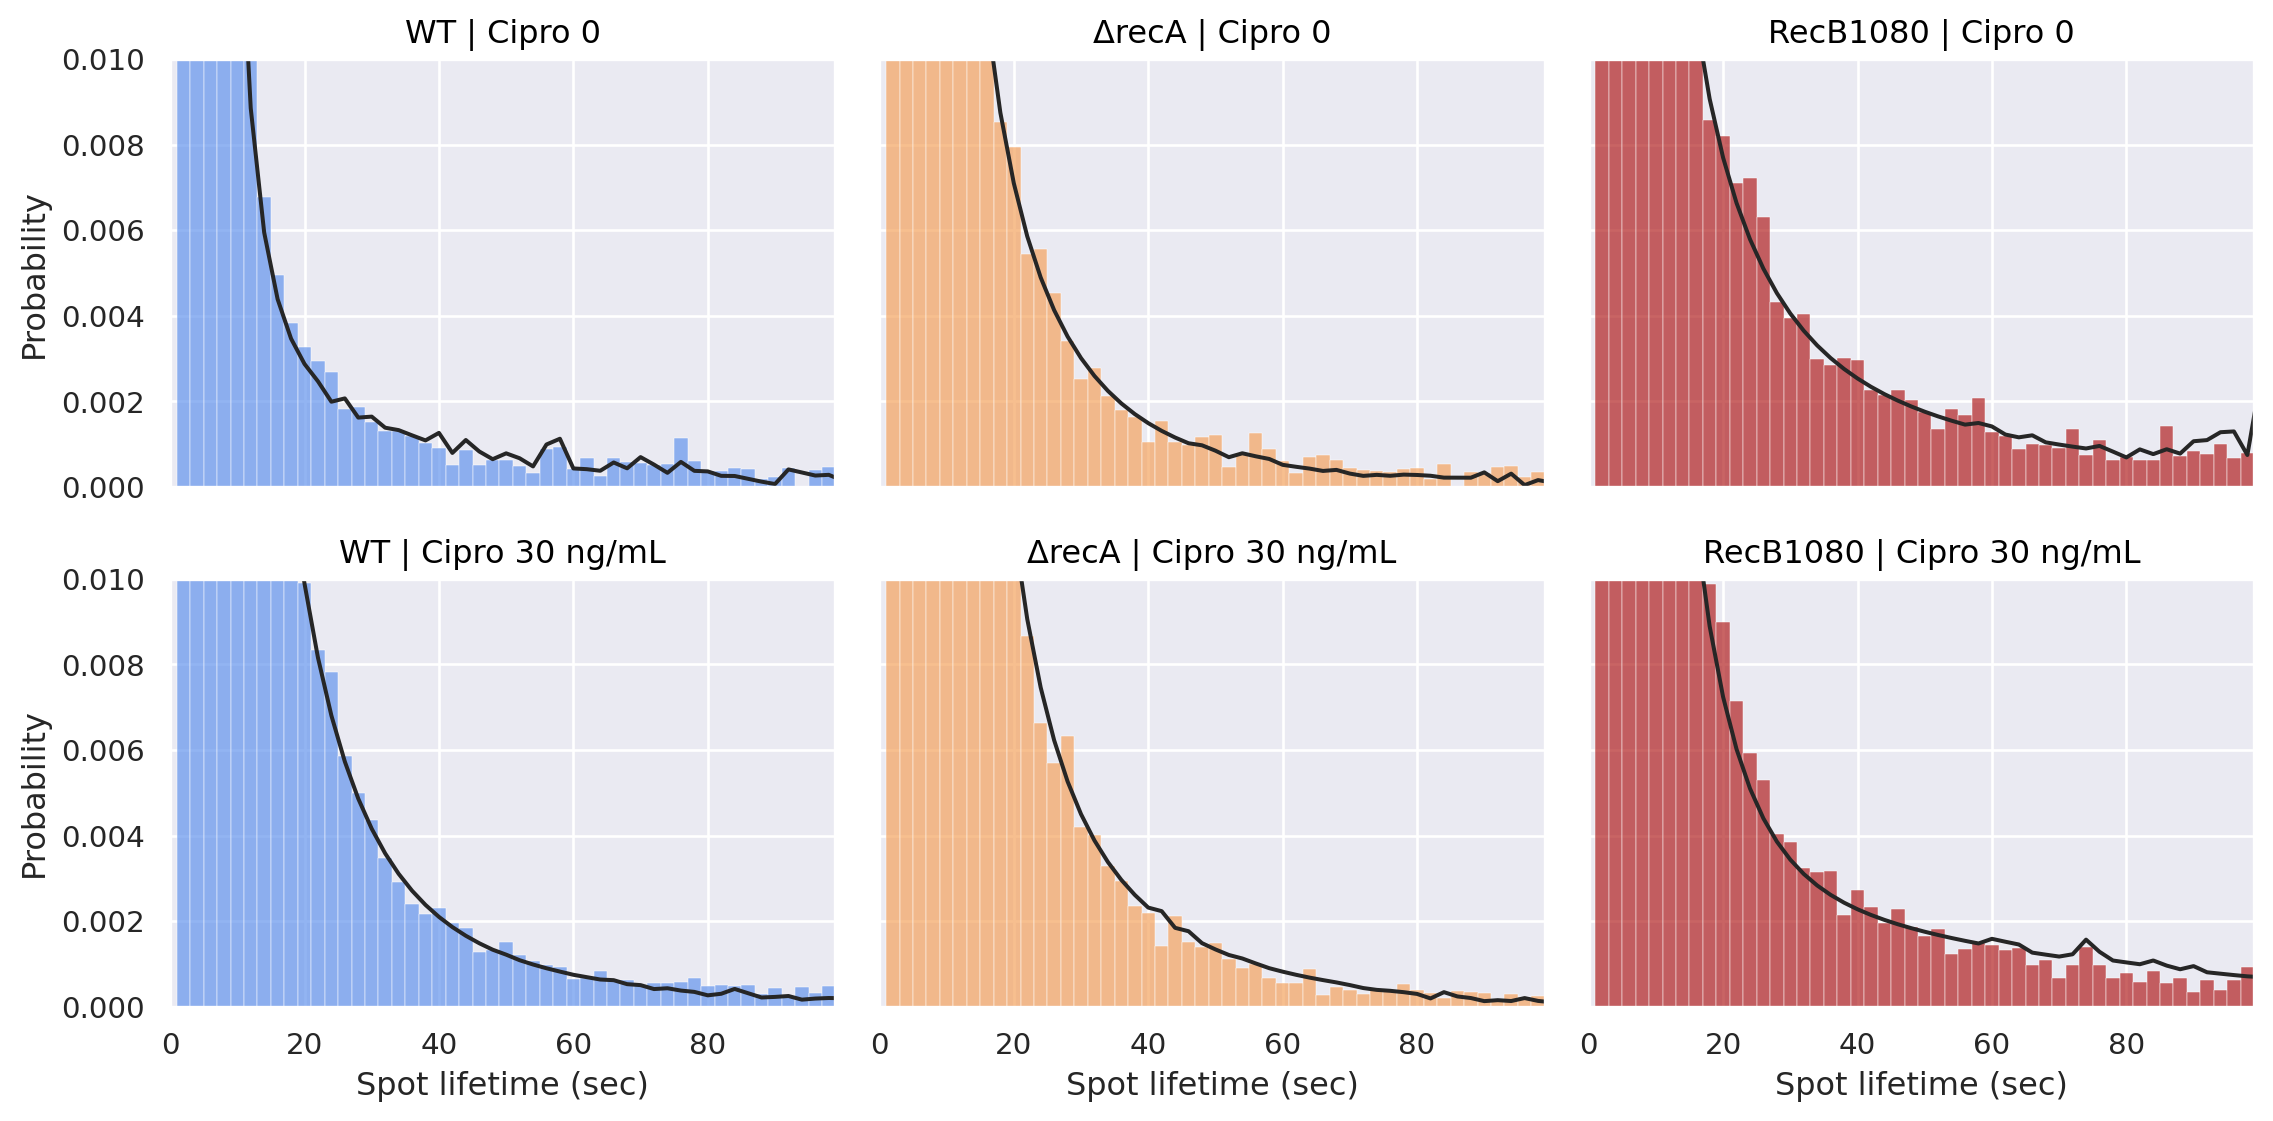

In [51]:
df = (triexp_fit
      .data
      .assign(TrackLength_s=lambda df: df.TrackLength.mul(2))
    #   .query('Dataset not in ["230725_1", "230126_DT23", "230919_2"]')
      )

(
    so.Plot(df, x='TrackLength_s', color='Strain')
    .layout(size=(12, 6))
    .facet(col='Strain', row='Cipro')
    .add(so.Bars(), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k'), so.Agg(), y='Fit', legend=False)
    .limit(x=(0, 99), y=(None, 0.01))
    .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick']))
    .label(x="Spot lifetime (sec)", y="Probability", color='', row='{}'.format)
)

In [52]:
display(triexp_fit.parameters.query('Group == "RecB1080, 0"').groupby('Parameter')['Value'].agg('mean'))

Parameter
Amplitude_1    1.419574
Amplitude_2    0.128677
Amplitude_3    0.005686
Rate_1         1.229981
Rate_2         0.354916
Rate_3        -0.036680
Name: Value, dtype: float64

#### Dissociation rates

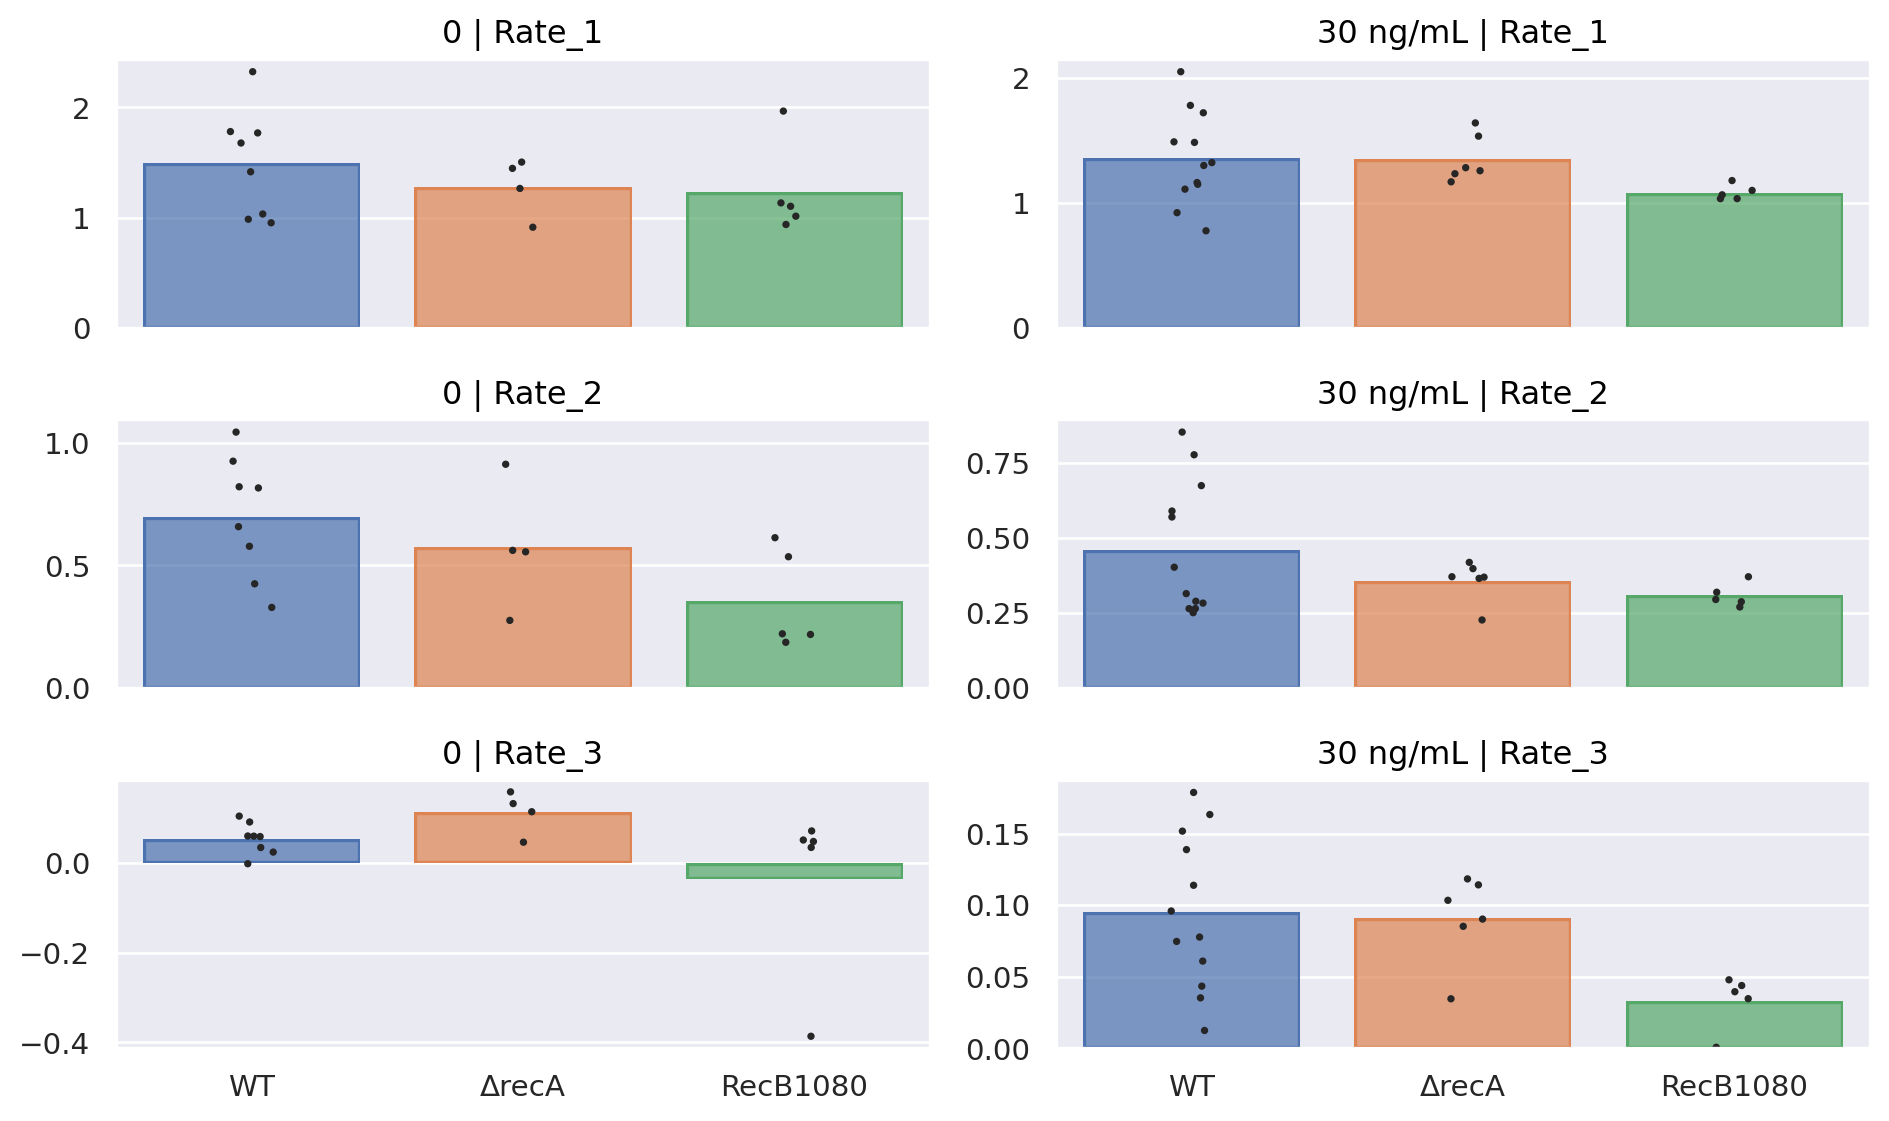

In [53]:
(
    so.Plot(triexp_fit.parameters, x='Strain', y='Value', color='Strain')
    .layout(size=(10,6))
    .facet(row='Parameter', col='Cipro', order={'row':['Rate_1', 'Rate_2', 'Rate_3']})
    .add(so.Bar(), so.Agg('mean'), legend=False)
    .add(so.Dots(color='k', marker='.', fillalpha=1), so.Jitter(), legend=False)
    .scale(color='deep')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="", color='')
)

#### Very long-lived dissociation rates

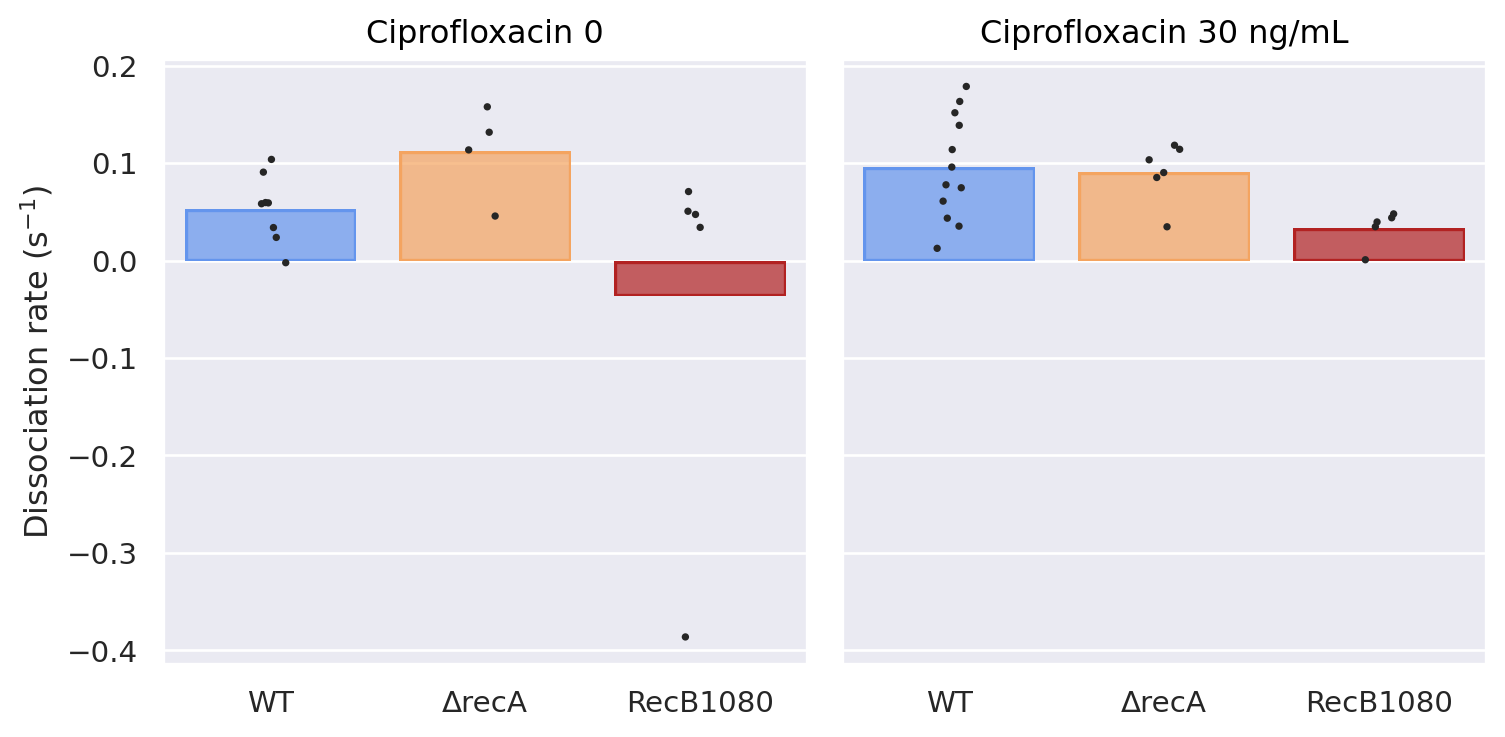

In [54]:
df = (triexp_fit
      .parameters
      .query("Parameter == 'Rate_3'")
      )

(
    so.Plot(df, x='Strain', y='Value', color='Strain')
    .layout(size=(8, 4))
    .facet(col='Cipro')
    .add(so.Bar(), so.Agg('mean'), legend=False)
    .add(so.Dots(marker='.', color='k', fillalpha=1), so.Jitter(), legend=False)
    .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick'],
                            order=['WT', 'ΔrecA', 'RecB1080']),
           x=so.Nominal(order=['WT', 'ΔrecA', 'RecB1080'])
           )
    .share(y='row')
    .limit(y=(None, None))
    .label(x="", y="Dissociation rate (s$^{-1}$)", color='', title="Ciprofloxacin {}".format)
    # .save(loc='D:\\DanielThedie\\Figures\\RecB_article_figures\\4_Mutants\\RecB_lifetimes.svg', format='svg', bbox_inches='tight')
)

#### Computing RecB spot lifetimes from the rates

In [36]:
def split_column(df, col, new, delimiter):
        df[new] = (df[col]
                        .str.split(delimiter, expand=True)
                        )
        return df

lifetimes_triexp = (triexp_fit
                    .parameters
                    .copy()
                    .pipe(lambda df: split_column(df, col='Parameter', new=['Parameter', 'Rate_type'], delimiter='_'))
                    .replace({'1':'Short', '2':'Long', '3':'VeryLong'})
                    .merge(bleaching_rates[['Dataset', 'Value']], on='Dataset', suffixes=(None, '_bleaching'))
                    .pipe(lambda df: pd.pivot_table(df, values=['Value'], index=['Group', 'Strain', 'Cipro', 'Dataset', 'Value_bleaching'], columns=['Parameter', 'Rate_type']))
                    .reset_index()
                    .assign(Lifetime_Short=lambda df: 1/(df.Value.Rate.Short - df.Value_bleaching) *2,
                            Lifetime_Long=lambda df: 1/(df.Value.Rate.Long - df.Value_bleaching) *2,
                            Lifetime_VeryLong=lambda df: 1/(df.Value.Rate.VeryLong - df.Value_bleaching) *2,
                            Population_Long=lambda df: df.Value.Amplitude.Long/(df.Value.Amplitude.Short+df.Value.Amplitude.Long+df.Value.Amplitude.VeryLong) *100,
                            Population_VeryLong=lambda df: df.Value.Amplitude.VeryLong/(df.Value.Amplitude.Short+df.Value.Amplitude.Long+df.Value.Amplitude.VeryLong) *100,
                            Population_Short=lambda df: 100 - df.Population_Long - df.Population_VeryLong
                            )
                    .drop(columns=['Value', 'Value_bleaching'], level=0)
                    .droplevel(['Parameter', 'Rate_type'], axis=1)
                    .melt(id_vars=['Group', 'Strain', 'Cipro', 'Dataset'])
                    .pipe(lambda df: split_column(df, col='variable', new=['Parameter', 'Rate_type'], delimiter='_'))
                    .drop(columns='variable')
                    )

In [ ]:
def fuse_cols(df, cols, new, delimiter):
        df[new] = (df[cols]
                   .astype('str')
                   .agg(delimiter.join, axis=1)
                   )
        return df

df = (lifetimes_triexp
      .pipe(lambda df: pd.pivot_table(df, values='value', index=['Strain', 'Cipro', 'Dataset', 'Rate_type'], columns='Parameter'))
      .groupby(['Strain', 'Cipro', 'Rate_type'], observed=True)
      .agg(Lifetime_mean=('Lifetime', 'mean'),
           Lifetime_std=('Lifetime', 'std'),
           Population_mean=('Population', 'mean'),
           Population_std=('Population', 'std')
           )
      .round(2)
      .reset_index()
      .assign(Strain=lambda df: df.Strain
                          .astype('category')
                          .cat.set_categories(['WT', 'ΔrecA', 'RecB1080'], ordered=True))
      .sort_values('Strain')
      .set_index(['Strain','Cipro','Rate_type'])
      )

display(df)

#### Plot lifetimes

In [ ]:
df = (lifetimes_triexp
      .replace({'Fast':'Short', 'Slow':'Long'})
      .query('Parameter == "Lifetime"  and Rate_type == "Long"')
      )

(
    so.Plot(df, x='Strain', y='value', color='Strain')
    .layout(size=(8, 4))
    .facet(col='Cipro')
    .add(so.Bar(), so.Agg('mean'), legend=False)
    .add(so.Dots(marker='.', color='k', fillalpha=1), so.Jitter(), legend=False)
    .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick'],
                            order=['WT', 'ΔrecA', 'RecB1080']),
           x=so.Nominal(order=['WT', 'ΔrecA', 'RecB1080'])
           )
    .share(y='row')
    .limit(y=(None, None))
    .label(x="", y="Lifetime on DNA (s)", color='', title="Ciprofloxacin {}".format)
    # .save(loc='D:\\DanielThedie\\Figures\\RecB_article_figures\\4_Mutants\\RecB_lifetimes.svg', format='svg', bbox_inches='tight')
)

#### Chi-square test to check the relevance of a triple-exponential fit

In [ ]:
from scipy.stats import chi2

for grp in triexp_fit.llf.keys():
    LR_statistic = -2*(lifetime_fit.llf[grp] - triexp_fit.llf[grp])
    p_val = chi2.sf(LR_statistic, 2)
    print(f'{grp}: p-value = {p_val}')

## Number of spots per cell area

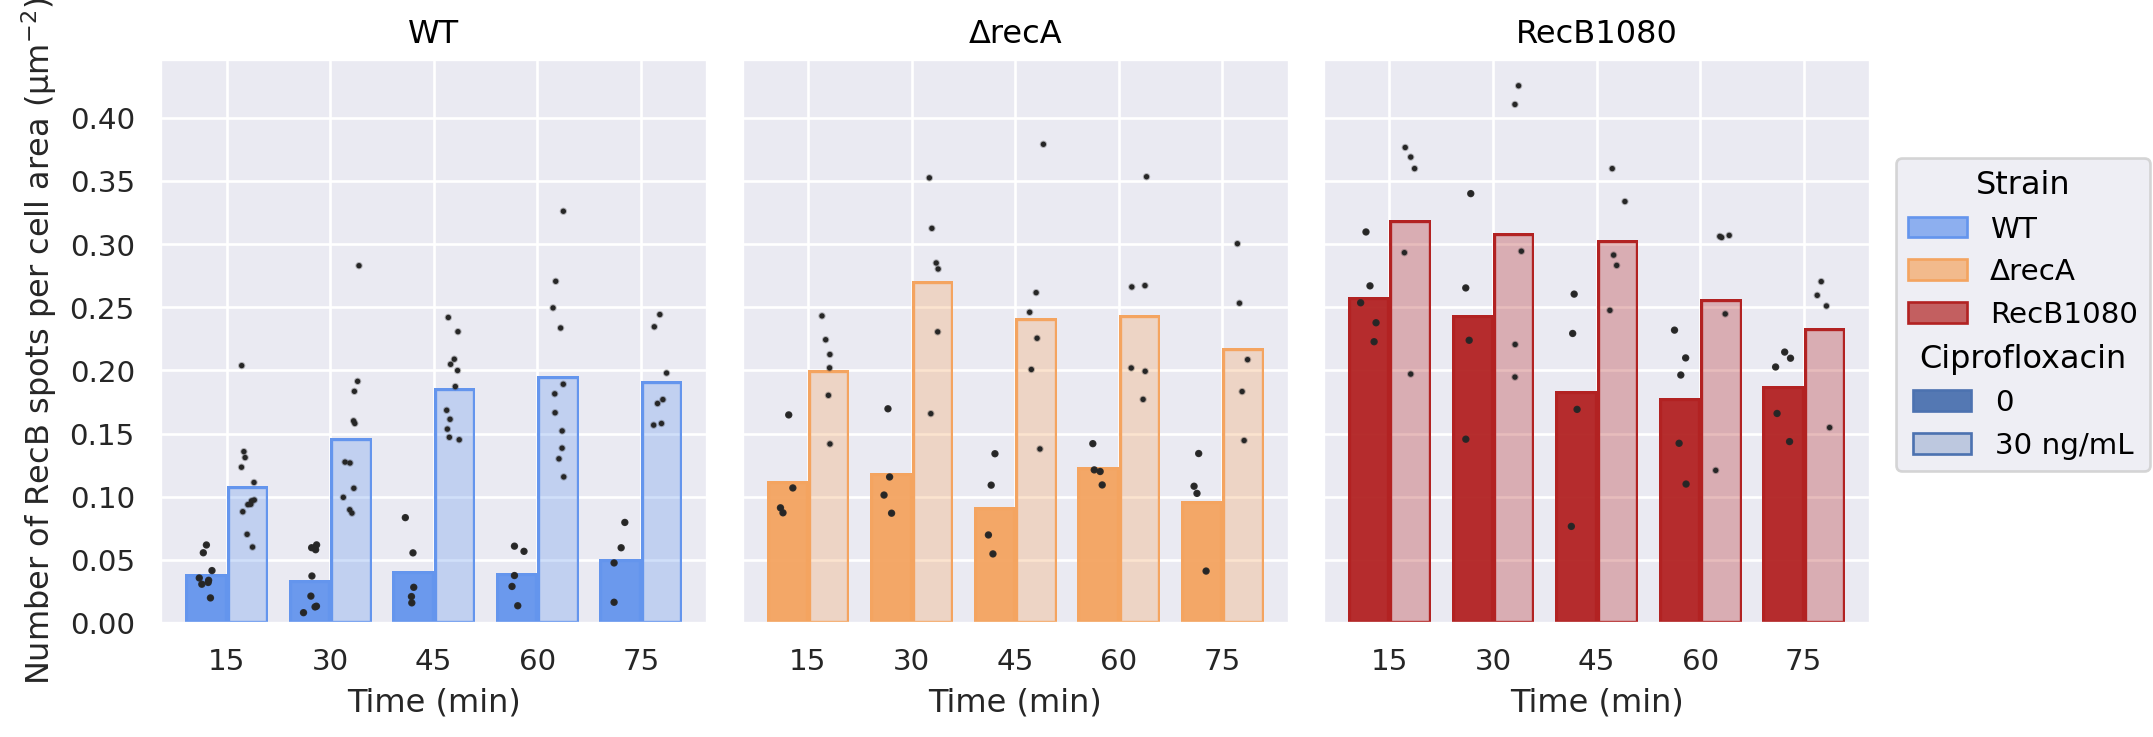

In [40]:
data = data.bin_column(object_name=['Bacteria_large', 'RecB_spots'], col='Time_min', binsize=15, binlabels='left')

df = (data
      .assign(object_name='RecB_spots',
              long_spot=lambda df: df.TrackLength.ge(5).replace({True:'Long', False:'Short'})
              )
      .get_parent_indices(object_name='RecB_spots')
      .add_from_parent(object_name='RecB_spots', col='Area')
      .RecB_spots
      .groupby(by=['Strain', 'Cipro', 'Dataset', 'Time_min_bin', 'long_spot', 'ParentIndices'])
      .agg({'Indices': 'count', 'Area': 'mean'})
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .assign(norm_count=lambda df: df.SpotCount / df.Area)
      .groupby(by=['Strain', 'Cipro', 'Dataset', 'long_spot', 'Time_min_bin'])
      .agg({'norm_count': 'sum'})
      .reset_index()
      .merge(data.Bacteria_large.groupby(['Dataset', 'Time_min_bin'])['Position'].count().reset_index().rename(columns={'Position':'nCells'}),
             how='left',
             on=['Dataset', 'Time_min_bin'],
             suffixes=('_old', None))
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(nCells=lambda df: df.nCells / 50,  # To account for the fact that 1 cell appears in 50 images of the timelapse
              norm_count=lambda df: df.norm_count / df.nCells)
      .query('Time_min_bin < 90 and long_spot == "Long"')
      )

(
 so.Plot(df, x='Time_min_bin', y='norm_count', color='Strain', alpha='Cipro')
 .layout(size=(10, 4))
 .facet(col='Strain', order={'col':['WT', 'ΔrecA', 'RecB1080']})
 .add(so.Bar(), so.Agg(), so.Dodge(by=['alpha']))
 .add(so.Dots(color='k', marker='.', fillalpha=1), so.Jitter(), so.Dodge(by=['alpha']), legend=False)
 .scale(alpha=so.Nominal(),
        color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick'], order=['WT', 'ΔrecA', 'RecB1080']),
        x=so.Continuous().tick(every=15)
        )
 .share(y=True)
 .limit(x=(None, None), y=(None, None))
 .label(x="Time (min)", y="Number of RecB spots per cell area (µm$^{-2}$)", color='Strain', alpha='Ciprofloxacin')
#  .save(loc='M:\\Figures\\RecB_article_figures\\2_Cipro_RecB\\RecB_counting_long_short.svg', format='svg', bbox_inches='tight')
 )

### More compact graph

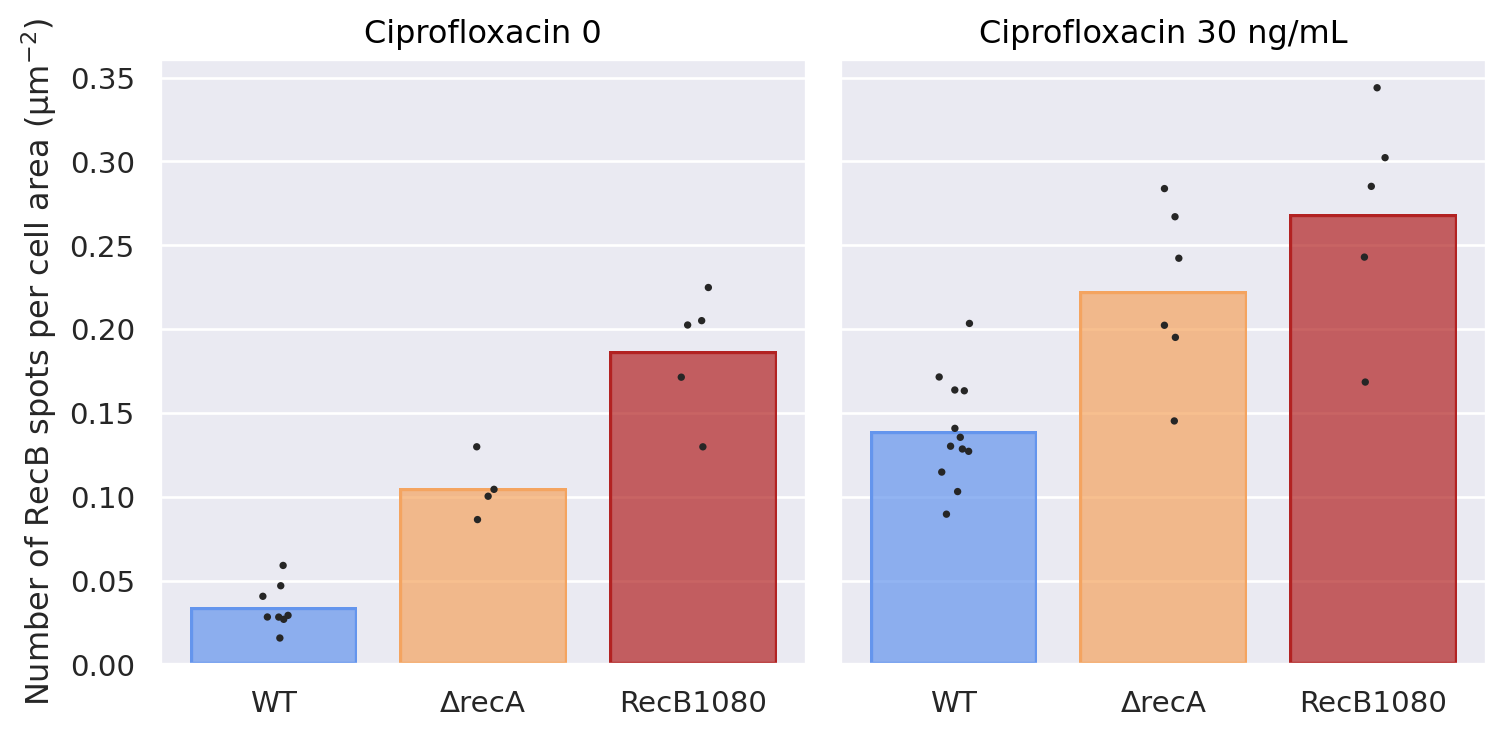

In [41]:
df = (data
      .assign(object_name='RecB_spots',
               long_spot=lambda df: df.TrackLength.ge(5).replace({True:'Long', False:'Short'})
               )
      .get_parent_indices(object_name='RecB_spots')
      .RecB_spots
      .groupby(by=['Strain', 'Cipro', 'Dataset', 'long_spot', 'ParentIndices'])
      .agg({'Indices': 'count', 'SpineLength': 'mean'})
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .assign(norm_count=lambda df: df.SpotCount / df.SpineLength)
      .groupby(by=['Strain', 'Cipro', 'long_spot', 'Dataset'])
      .agg({'norm_count': 'sum'})
      .reset_index()
      .merge(data.Bacteria_large.groupby('Dataset')['Position'].count().reset_index().rename(columns={'Position':'nCells'}),
             how='left',
             on='Dataset',
             suffixes=('_old', None))
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(nCells=lambda df: df.nCells / 50,
              norm_count=lambda df: df.norm_count / df.nCells
              )
      .query('long_spot == "Long"')
      )

(
 so.Plot(df, x='Strain', y='norm_count', color='Strain')
 .layout(size=(8, 4))
 .facet(col='Cipro')
 .add(so.Bar(), so.Agg('mean'), legend=False)
 .add(so.Dots(color='k', marker='.', fillalpha=1), so.Jitter(), legend=False)
 .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick'], order=['WT', 'ΔrecA', 'RecB1080']),
        x=so.Nominal(order=['WT', 'ΔrecA', 'RecB1080'])
        )
 .share(y=True)
 .limit(x=(None, None), y=(None, None))
 .label(x='', y='Number of RecB spots per cell area (µm$^{-2}$)', title='Ciprofloxacin {}'.format, color='Strain')
#  .save(loc='D:\\DanielThedie\\Figures\\RecB_article_figures\\4_Mutants\\RecB_counting.svg', format='svg', bbox_inches='tight')
 )

### Estimate the rate of DSB formation

DSB_rate     
                      mean  std
Strain   Cipro                 
WT       0             0.8  0.6
         30 ng/mL      5.6  2.4
ΔrecA    0             3.7  1.6
         30 ng/mL     13.2  4.9
RecB1080 0             3.7  1.5
         30 ng/mL      7.5  1.5

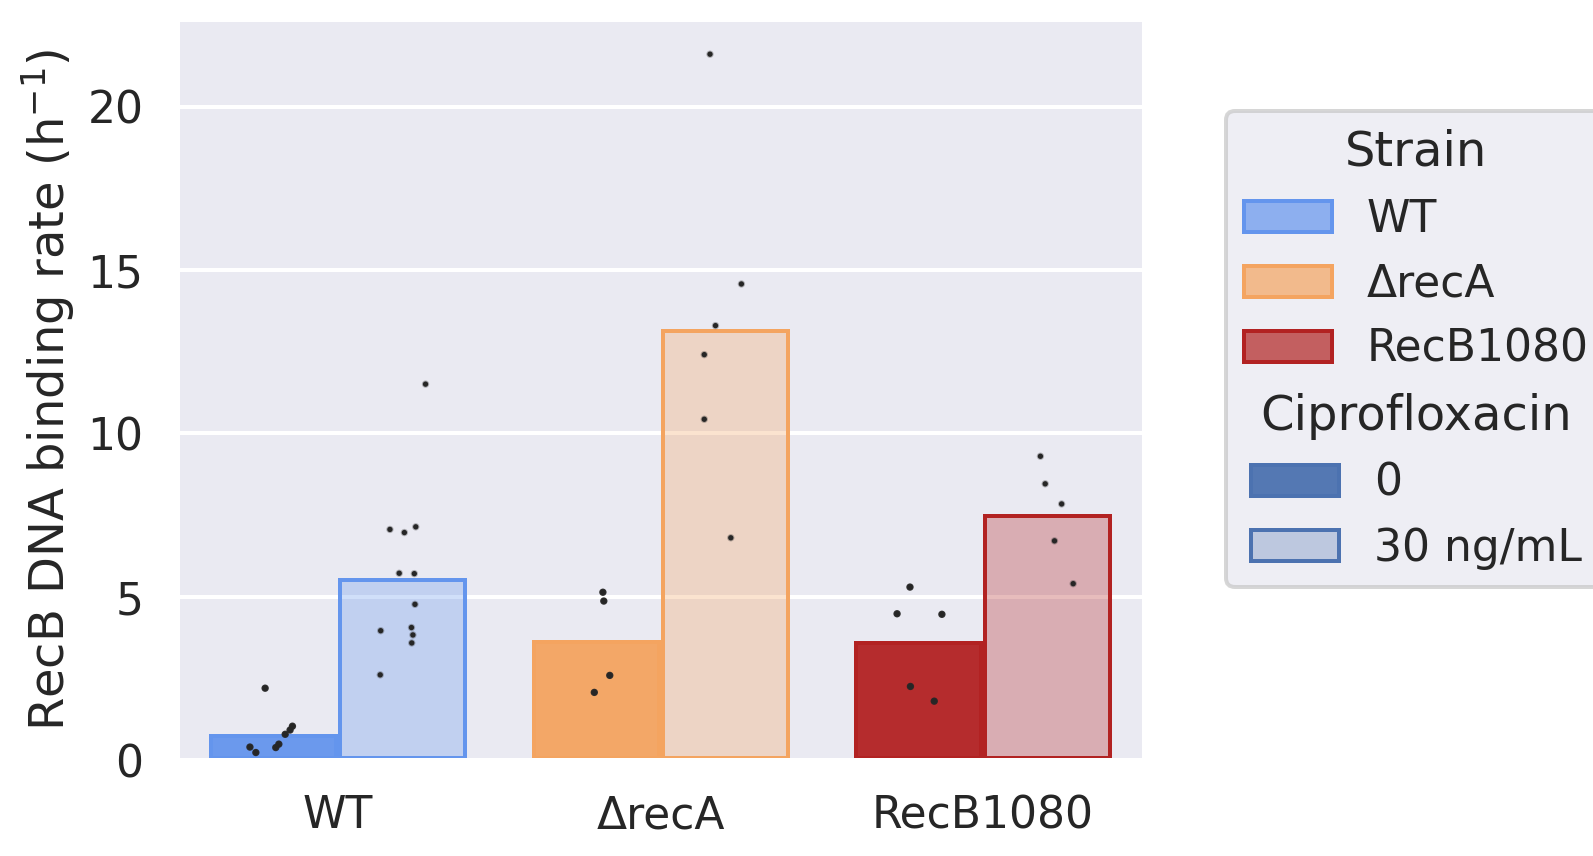

In [64]:
df = (data
      .RecB_spots
      .query('Time_min_bin < 90 and Frame > 0')
      .groupby(by=['Group', 'Dataset', 'ParentIndices'])
      .agg({'Indices': 'count'})
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .groupby(by=['Group', 'Dataset'])
      .agg({'SpotCount': 'sum'})
      .reset_index()
      .merge(data
             .Bacteria_large
             .groupby(['Dataset'])
             .agg({'Position':'count'})
             .reset_index()
             .rename(columns={'Position':'nCells'}),
             how='left',
             on=['Dataset'],
             suffixes=('_old', None)
             )
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(nCells=lambda df: df.nCells / 50,  # To account for the fact that 1 cell appears in 50 images of the timelapse
              norm_count=lambda df: df.SpotCount / df.nCells
              )
      .merge(lifetimes_biexp
             .query('Parameter == "Population" and Rate_type == "Long"')
             .rename(columns={'value':'long_lived'})
             .assign(long_lived=lambda df: (df.long_lived)/100),  # Subtract long-lived population in Gam data
             on=['Group', 'Dataset']
             )
      .assign(DSB_rate=lambda df: df.norm_count /98*60*60 *df.long_lived)  # Rate of DSB formation (h-1)
      )

display(df
        .assign(Strain=lambda df: df.Strain
                                   .astype('category')
                                   .cat.set_categories(['WT', 'ΔrecA', 'RecB1080'], ordered=True))
        .sort_values('Strain')
        .groupby(['Strain', 'Cipro'], observed=True)
        .agg({'DSB_rate':['mean', 'std']})
        .round(1)
        )

(
    so.Plot(df, x='Strain', y='DSB_rate', color='Strain', alpha='Cipro')
#     .layout(size=(8,5))
    .add(so.Bar(), so.Agg(), so.Dodge(by=['alpha']))
    .add(so.Dots(color='k', fillalpha=1, marker='.'), so.Jitter(), so.Dodge(by=['alpha']), legend=False)
    .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick'], order=['WT', 'ΔrecA', 'RecB1080']),
           x=so.Nominal(order=['WT', 'ΔrecA', 'RecB1080'])
           )
    .share(y=False)
    .limit(y=(0, None))
    .label(x="", y="RecB DNA binding rate (h$^{-1}$)", alpha='Ciprofloxacin')
    .theme(plotting_context('talk'))
#     .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/DSB_rate.svg', format='svg', bbox_inches='tight')
)

#### RecB recruitment rate normalised by cell length

DSB_rate     
                      mean  std
Strain   Cipro                 
WT       0             0.3  0.2
         30 ng/mL      1.4  0.6
ΔrecA    0             1.0  0.4
         30 ng/mL      3.8  1.4
RecB1080 0             0.9  0.4
         30 ng/mL      1.8  0.5

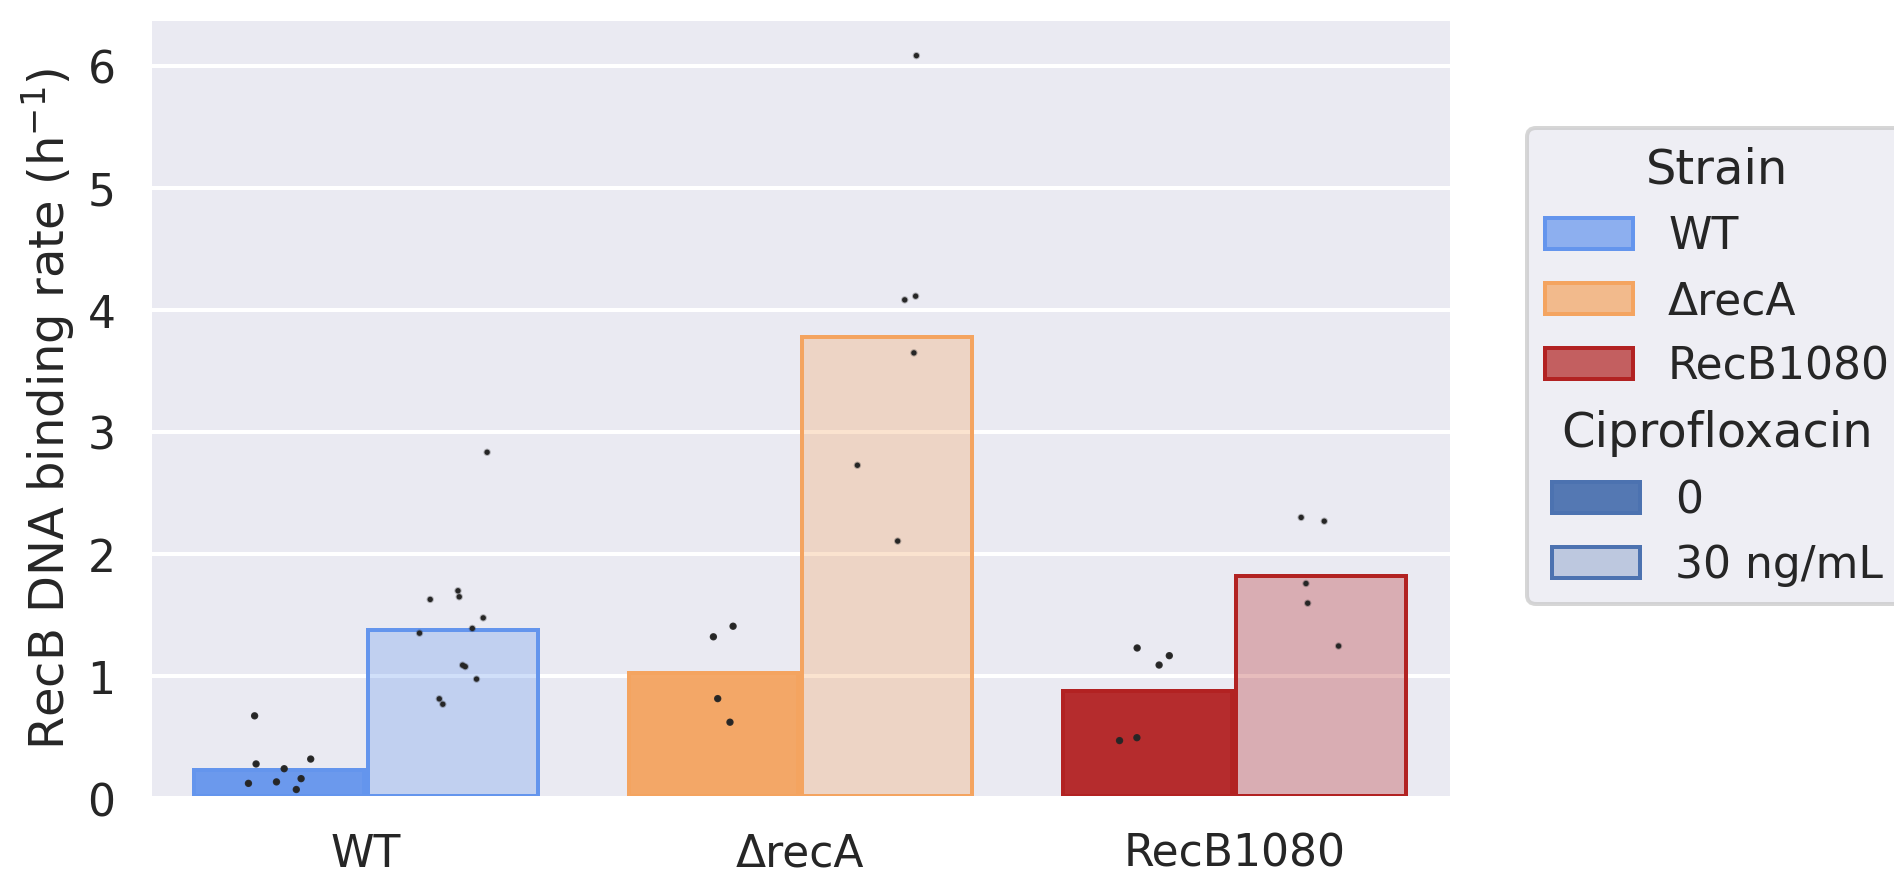

In [65]:
df = (data
      .RecB_spots
      .query('Time_min_bin < 90 and Frame > 0')
      .groupby(by=['Group', 'Dataset', 'ParentIndices'])
      .agg({'Indices': 'count', 'SpineLength':'mean'})
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .assign(SpotCount=lambda df: df.SpotCount / df.SpineLength)
      .groupby(by=['Group', 'Dataset'])
      .agg({'SpotCount': 'sum'})
      .reset_index()
      .merge(data
             .Bacteria_large
             .groupby(['Dataset'])
             .agg({'Position':'count'})
             .reset_index()
             .rename(columns={'Position':'nCells'}),
             how='left',
             on=['Dataset'],
             suffixes=('_old', None)
             )
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(nCells=lambda df: df.nCells / 50,  # To account for the fact that 1 cell appears in 50 images of the timelapse
              norm_count=lambda df: df.SpotCount / df.nCells
              )
      .merge(lifetimes_biexp
             .query('Parameter == "Population" and Rate_type == "Long"')
             .rename(columns={'value':'long_lived'})
             .assign(long_lived=lambda df: (df.long_lived)/100),  # Subtract long-lived population in Gam data
             on=['Group', 'Dataset']
             )
      .assign(DSB_rate=lambda df: df.norm_count /98*60*60 *df.long_lived)  # Rate of DSB formation (h-1)
      )

display(df
        .assign(Strain=lambda df: df.Strain
                                   .astype('category')
                                   .cat.set_categories(['WT', 'ΔrecA', 'RecB1080'], ordered=True))
        .sort_values('Strain')
        .groupby(['Strain', 'Cipro'], observed=True)
        .agg({'DSB_rate':['mean', 'std']})
        .round(1)
        )

(
    so.Plot(df, x='Strain', y='DSB_rate', color='Strain', alpha='Cipro')
    .layout(size=(8,5))
    .add(so.Bar(), so.Agg(), so.Dodge(by=['alpha']))
    .add(so.Dots(color='k', fillalpha=1, marker='.'), so.Jitter(), so.Dodge(by=['alpha']), legend=False)
    .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick'], order=['WT', 'ΔrecA', 'RecB1080']),
           x=so.Nominal(order=['WT', 'ΔrecA', 'RecB1080'])
           )
    .share(y=False)
    .limit(y=(0, None))
    .label(x="", y="RecB DNA binding rate (h$^{-1}$)", alpha='Ciprofloxacin')
    .theme(plotting_context('talk'))
#     .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/DSB_rate.svg', format='svg', bbox_inches='tight')
)

## RecB position in the cell

/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommo

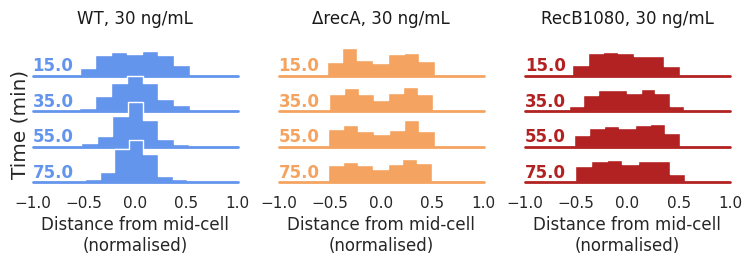

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

df = (data
      .assign(object_name='RecB_spots', midCellDist=lambda df: df.SpineCurvilinearCoord / df.SpineLength - 0.5)
      .bin_column(object_name='RecB_spots', col='Time_min', binsize=20, binlabels='left')
      .RecB_spots
      .query('Time_min_bin < 95 and Cipro == "30 ng/mL" and TrackLength >= 5')
      )

# Initialize the FacetGrid object
g = sns.FacetGrid(df, row="Time_min_bin", col='Group', hue='Group', aspect=6, height=.5, palette=['cornflowerblue', 'sandybrown', 'firebrick'])
g.map(sns.histplot, 'midCellDist', binwidth=0.15, common_norm=False, stat='probability', alpha=1, element='step', edgecolor='w')
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(row, color, label):
      ax = plt.gca()
      ax.text(0, .2, row.iloc[0], fontweight="bold", color=color,
              ha="left", va="center", transform=ax.transAxes)
      if row.iloc[0] == 15.0:
            ax.text(.5, 1.2, label, color='k',
                  ha="center", va="center", transform=ax.transAxes)

g.map(label, 'Time_min_bin')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)
g.figure.supylabel('Time (min)', x=.1, y=.4)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel='Distance from mid-cell\n(normalised)', xlim=(-1, 1))
g.despine(bottom=True, left=True)
plt.show()

# plt.savefig(fname='D:\\DanielThedie\\Figures\\RecB_article_figures\\4_Mutants\\RecB_position.svg', format='svg', bbox_inches='tight')